# Imporing Libraries

In [ ]:
import numpy as np 
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix
import keras
from keras import layers
from keras import models
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation,  AveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
import datetime

my_devices = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_visible_devices(devices= my_devices, device_type='GPU')

seed = 240
np.random.seed(seed)
tf.random.set_seed(seed)



In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
    # print(device_lib.list_local_devices())

Default GPU Device: /device:GPU:0


# Pulling the Data From GitHub


In [ ]:
!git clone https://github.com/hrmoradi/Workshop_data # goes to your cotent folder

Cloning into 'Workshop_data'...
remote: Enumerating objects: 5859, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 5859 (delta 2), reused 18 (delta 2), pack-reused 5840
Receiving objects: 100% (5859/5859), 1.13 GiB | 21.99 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Updating files: 100% (6259/6259), done.


# Import the data

In [ ]:
# Take all file names in different directory
base_directory     = '/content/Workshop_data/chest_xray/'

train_pne_dir = os.listdir(base_directory +'/train/PNEUMONIA/')
train_nor_dir = os.listdir(base_directory +'/train/NORMAL/')

val_pne_dir  = os.listdir(base_directory +'/val/PNEUMONIA/')
val_nor_dir  = os.listdir(base_directory +'/val/NORMAL/')

test_pne_dir = os.listdir(base_directory +'/test/PNEUMONIA/')
test_nor_dir = os.listdir(base_directory +'/test/NORMAL/')

## Check the size and pixel ranges of pictures


Type of the image :  <class 'imageio.core.util.Array'>
Shape of the image : (1364, 1654)
Dimension of Image 2
dtype:  uint8
Maximum RGB value in this image 255
Minimum RGB value in this image 0

Type of the image :  <class 'imageio.core.util.Array'>
Shape of the image : (1302, 1692)
Dimension of Image 2
dtype:  uint8
Maximum RGB value in this image 255
Minimum RGB value in this image 0


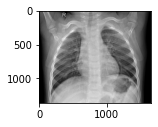

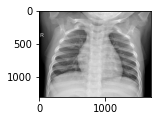

In [ ]:
from PIL import Image
# ! pip install imageio
import imageio

for i in range(0,2):
    pic= train_nor_dir[i]
    pic = imageio.imread(base_directory+'/train/NORMAL/' + pic)
    plt.figure(figsize = (2,2))
    plt.imshow(pic, cmap='gray')
    print()
    print('Type of the image : ' , type(pic))
    print('Shape of the image : {}'.format(pic.shape))
    print('Dimension of Image {}'.format(pic.ndim))
    print('dtype: ', pic.dtype)
    print('Maximum RGB value in this image {}'.format(pic.max()))
    print('Minimum RGB value in this image {}'.format(pic.min()))

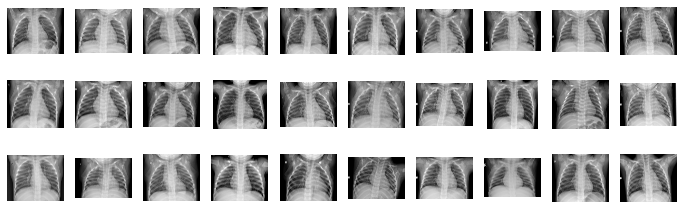

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
n_rows = 3
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        pic= train_nor_dir[index]
        pic = imageio.imread(base_directory+'/train/NORMAL/' + pic)
        plt.imshow(pic, cmap='gray')
        plt.axis('off')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
# plt.save_fig('ChestImages')
plt.show()

# Import and preprocessing the data

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

color_mode="grayscale" # "rgb"
img_dims = 224
batch_size = 32

train_gen = ImageDataGenerator(rescale=1/255.0, zoom_range=0.3, vertical_flip=True, validation_split=0.2)
val_gen = ImageDataGenerator(rescale=1/255.0)
test_gen = ImageDataGenerator(rescale=1/255.0)

train_generator = train_gen.flow_from_directory(
    directory= base_directory+"/train/",
    target_size=(img_dims, img_dims),
    # color_mode = color_mode,
    batch_size=batch_size,
    class_mode="binary",  
    shuffle=True,
    subset='training')

valid_generator = train_gen.flow_from_directory(
    directory= base_directory+"/val/",
    target_size=(img_dims, img_dims),
    # color_mode = color_mode,
    batch_size=batch_size,
    class_mode="binary",
    shuffle=True, 
    subset='validation')
  
test_generator = test_gen.flow_from_directory(
    directory=base_directory+"/test/",
    target_size=(img_dims, img_dims),
    # color_mode= color_mode,
    batch_size=batch_size,  
    class_mode='binary',  
    shuffle=False)


Found 4173 images belonging to 2 classes.
Found 83 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Frequency of the normal+infected: 
             normal  pnuemonia
train         1073       3100
validation      31         39
test           234        390


(array([0, 1, 2]),
 [Text(0, 0, 'train'), Text(1, 0, 'validation'), Text(2, 0, 'test')])

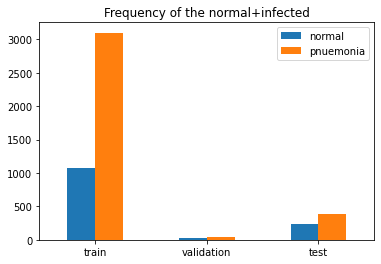

In [ ]:
from collections import Counter

train_counter = list(Counter(train_generator.classes).values())
val_counter   = list(Counter(valid_generator.classes).values())
test_counter  = list(Counter(test_generator.classes).values())

summa_dat = pd.DataFrame([train_counter, val_counter, test_counter], columns=('normal', 'pnuemonia'), index = ['train', 'validation', 'test'])
print('Frequency of the normal+infected: \n', summa_dat)
summa_dat.plot(kind='bar', title='Frequency of the normal+infected')
plt.xticks(rotation=0, horizontalalignment="center")

# A basic CNN model

### Creating a basic model using Sequential API

In [ ]:
model_1 = keras.Sequential([
   Conv2D(64, 3, input_shape=(img_dims,img_dims, 3), activation='relu'),
   Conv2D(32, 3, activation='relu'),
   MaxPool2D(pool_size=(2,2)),  
   Dropout(0.5),    
   Flatten(),
   Dense(128, activation='relu'),  
   Dense(1, activation='sigmoid')
])
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 32)      18464     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 110, 110, 32)      0         
                                                                 
 flatten (Flatten)           (None, 387200)            0         
                                                                 
 dense (Dense)               (None, 128)               49561728  
                                                        

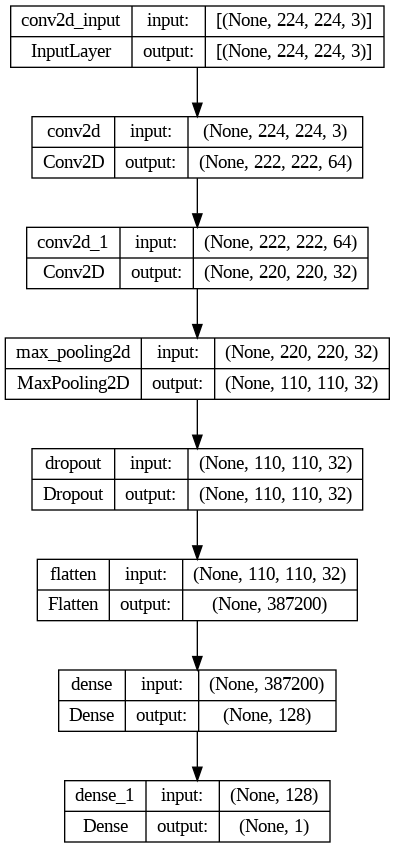

In [ ]:
keras.utils.plot_model(model_1, "basic_model_1.png", show_shapes=True)

## Compile the model

In [ ]:
model_1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Training and Evaluating the Model

In [ ]:
epochs = 7
model1_hist = model_1.fit(x=train_generator,
                    steps_per_epoch=train_generator.n//batch_size,
                    validation_data=valid_generator,
                    validation_steps=valid_generator.n //batch_size,
                    epochs=epochs,
                    verbose = 1)

Epoch 1/7
130/130 [==============================] - 89s 653ms/step - loss: 0.7601 - accuracy: 0.7783 - val_loss: 0.6060 - val_accuracy: 0.6094
Epoch 2/7
130/130 [==============================] - 87s 667ms/step - loss: 0.3106 - accuracy: 0.8701 - val_loss: 0.5034 - val_accuracy: 0.7812
Epoch 3/7
130/130 [==============================] - 88s 680ms/step - loss: 0.2762 - accuracy: 0.8858 - val_loss: 0.3506 - val_accuracy: 0.8281
Epoch 4/7
130/130 [==============================] - 85s 654ms/step - loss: 0.2463 - accuracy: 0.9010 - val_loss: 0.2464 - val_accuracy: 0.9219
Epoch 5/7
130/130 [==============================] - 84s 645ms/step - loss: 0.2251 - accuracy: 0.9056 - val_loss: 0.2652 - val_accuracy: 0.8906
Epoch 6/7
130/130 [==============================] - 83s 639ms/step - loss: 0.2486 - accuracy: 0.9065 - val_loss: 0.4471 - val_accuracy: 0.7344
Epoch 7/7
130/130 [==============================] - 83s 641ms/step - loss: 0.2476 - accuracy: 0.8998 - val_loss: 0.3495 - val_accuracy:

In [ ]:
def draw_hist_f(hist):
    
    pd.DataFrame(hist.history).plot(figsize=(8, 5))
    plt.title('Learning curve of the model')
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.9))
    plt.show()


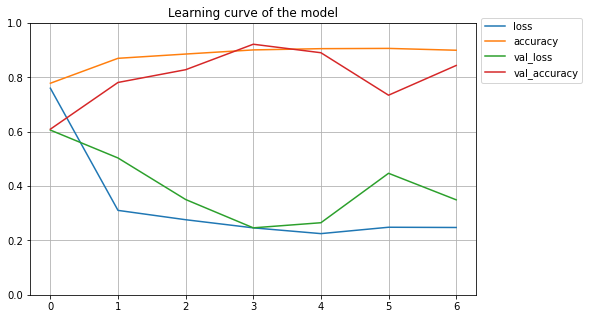

In [ ]:
draw_hist_f(model1_hist)

### Evaluate the model on the test set


In [ ]:
model_1_test = model_1.evaluate(test_generator, steps = test_generator.n//batch_size) # 2 more calls: .predict    .predict_proba. What are the diff?
print(model_1.metrics_names)
print(model_1_test)
print("Accuracy = ",model_1_test[1])

19/19 [==============================] - 6s 284ms/step - loss: 0.5362 - accuracy: 0.8174
['loss', 'accuracy']
[0.5362216830253601, 0.8174341917037964]
Accuracy =  0.8174341917037964


In [ ]:
# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=8)

# Transfer Learning

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/applications
from tensorflow.keras import applications as app

# img_input = tf.keras.layers.Input(shape=(img_dims, img_dims,1))
# img_conc = tf.keras.layers.Concatenate()([img_input, img_input, img_input])  

# tl_model = app.ResNet152V2(input_shape=None, include_top=False, weights='imagenet', input_tensor=img_conc, pooling='avg') # no support for depth 1
tl_model = app.ResNet50V2(input_shape=(224,224,3), include_top=False, weights='imagenet') # no support for depth 1
# tl_model = app.DenseNet201(input_shape=None,include_top=False, weights='imagenet',input_tensor=img_conc, pooling='avg') # no support for depth 1
# tl_model = app.EfficientNetB7(input_shape=None,include_top=False, weights='imagenet',input_tensor=img_conc, pooling='avg')

### training full model

In [ ]:
x = tl_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
output = tf.keras.layers.Dense(1,activation='sigmoid')(x)

tl_full_model = Model(inputs = tl_model.input, outputs = output)
# tl_full_model.summary()
tl_full_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
tl_full_model_hist = tl_full_model.fit(x=train_generator,
                    steps_per_epoch=train_generator.n//batch_size,
                    validation_data=valid_generator,
                    validation_steps=valid_generator.n //batch_size,
                    epochs=7,
                    callbacks=[early_stopping,lr],
                    verbose = 1)

tl_full_model = tl_full_model.evaluate(test_generator, steps = test_generator.n//batch_size) # 2 more calls: .predict    .predict_proba. What are the diff?
print("Accuracy = ",tl_full_model[1])

Epoch 1/7
130/130 [==============================] - 118s 672ms/step - loss: 0.2567 - accuracy: 0.8995 - val_loss: 28.6371 - val_accuracy: 0.3438 - lr: 0.0010
Epoch 2/7
130/130 [==============================] - 84s 649ms/step - loss: 0.1619 - accuracy: 0.9382 - val_loss: 2.1764 - val_accuracy: 0.5938 - lr: 0.0010
Epoch 3/7
130/130 [==============================] - 84s 642ms/step - loss: 0.1547 - accuracy: 0.9413 - val_loss: 3.6301 - val_accuracy: 0.6719 - lr: 0.0010
Epoch 4/7
130/130 [==============================] - 84s 649ms/step - loss: 0.1438 - accuracy: 0.9478 - val_loss: 5.3347 - val_accuracy: 0.6406 - lr: 0.0010
Epoch 5/7
130/130 [==============================] - 84s 643ms/step - loss: 0.1435 - accuracy: 0.9454 - val_loss: 1.5168 - val_accuracy: 0.6562 - lr: 0.0010
Epoch 6/7
130/130 [==============================] - 85s 650ms/step - loss: 0.1198 - accuracy: 0.9560 - val_loss: 0.0975 - val_accuracy: 0.9844 - lr: 0.0010
Epoch 7/7
19/19 [==============================] - 5s 26

### Training Head

In [ ]:
tl_freez_model = app.ResNet50V2(input_shape=(224,224,3), include_top=False, weights='imagenet') 

# Make loaded layers as non-trainable
for layer in tl_freez_model.layers:
    layer.trainable = False

x = tl_freez_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
output = tf.keras.layers.Dense(1,activation='sigmoid')(x)

# Create model object
tl_freez_full_model = Model(inputs = tl_freez_model.input, outputs = output)
# tl_freez_full_model.summary()
tl_freez_full_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
tl_freez_full_model_hist = tl_freez_full_model.fit(x=train_generator,
                    steps_per_epoch=train_generator.n//batch_size,
                    validation_data=valid_generator,
                    validation_steps=valid_generator.n //batch_size,
                    epochs=7,
                    callbacks=[early_stopping,lr],
                    verbose = 1)

tl_freez_full_model = tl_freez_full_model.evaluate(test_generator, steps = test_generator.n//batch_size) # 2 more calls: .predict    .predict_proba. What are the diff?
print("Accuracy = ",tl_freez_full_model[1])


Epoch 1/7
130/130 [==============================] - 91s 664ms/step - loss: 0.2556 - accuracy: 0.8974 - val_loss: 0.5556 - val_accuracy: 0.7656 - lr: 0.0010
Epoch 2/7
130/130 [==============================] - 83s 639ms/step - loss: 0.1549 - accuracy: 0.9379 - val_loss: 0.2402 - val_accuracy: 0.9062 - lr: 0.0010
Epoch 3/7
130/130 [==============================] - 83s 639ms/step - loss: 0.1411 - accuracy: 0.9440 - val_loss: 0.1685 - val_accuracy: 0.9219 - lr: 0.0010
Epoch 4/7
130/130 [==============================] - 84s 642ms/step - loss: 0.1330 - accuracy: 0.9490 - val_loss: 0.1357 - val_accuracy: 0.9219 - lr: 0.0010
Epoch 5/7
130/130 [==============================] - 83s 637ms/step - loss: 0.1243 - accuracy: 0.9515 - val_loss: 0.2406 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 6/7
130/130 [==============================] - 84s 643ms/step - loss: 0.1245 - accuracy: 0.9536 - val_loss: 0.1066 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 7/7
19/19 [==============================] - 6s 264m

### training head + some conv layers

In [ ]:
tl_freez_model = app.ResNet50V2(input_shape=(224,224,3), include_top=False, weights='imagenet') 

# Make loaded layers as non-trainable
for layer in tl_freez_model.layers:
  if layer.name == "conv4_block1_1_conv":
    print("found conv4_block1_1_conv")
    break
  layer.trainable = False

x = tl_freez_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
output = tf.keras.layers.Dense(1,activation='sigmoid')(x)

# Create model object
tl_freez_full_model = Model(inputs = tl_freez_model.input, outputs = output)
# tl_freez_full_model.summary()
tl_freez_full_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
tl_freez_full_model_hist = tl_freez_full_model.fit(x=train_generator,
                    steps_per_epoch=train_generator.n//batch_size,
                    validation_data=valid_generator,
                    validation_steps=valid_generator.n //batch_size,
                    epochs=7,
                    callbacks=[early_stopping,lr],
                    verbose = 1)

tl_freez_full_model = tl_freez_full_model.evaluate(test_generator, steps = test_generator.n//batch_size) # 2 more calls: .predict    .predict_proba. What are the diff?
print("Accuracy = ",tl_freez_full_model[1])


found conv4_block1_1_conv
Epoch 1/7
130/130 [==============================] - 103s 652ms/step - loss: 0.2190 - accuracy: 0.9162 - val_loss: 23.5523 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 2/7
130/130 [==============================] - 83s 641ms/step - loss: 0.1413 - accuracy: 0.9495 - val_loss: 0.5613 - val_accuracy: 0.9062 - lr: 0.0010
Epoch 3/7
130/130 [==============================] - 84s 648ms/step - loss: 0.1230 - accuracy: 0.9553 - val_loss: 0.0630 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 4/7
130/130 [==============================] - 84s 643ms/step - loss: 0.1079 - accuracy: 0.9597 - val_loss: 0.0892 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 5/7
130/130 [==============================] - 84s 645ms/step - loss: 0.1019 - accuracy: 0.9657 - val_loss: 0.0657 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 6/7
130/130 [==============================] - 83s 642ms/step - loss: 0.0806 - accuracy: 0.9684 - val_loss: 0.0667 - val_accuracy: 0.9531 - lr: 0.0010
Epoch 7/7
19/19 [=============